Run these, then use these results to test multiple hidden models and look at weights for both of these networks.
Then run annealed for multiple epochs, using result from fixed dropout, also run the newBob learning.

L1 Experiments

In [2]:
# %load Experiments/l1Experiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = [0.005,0.001,0.0005,0.0001,0.00005]
l2_weight = 0.000
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("l1RegExperiments", writeback = True)

stats = []
rate = 2

for index,item in enumerate(l1_weight):
    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        ''' elif layer == 1:
            odim = 600
            model.add_layer(Sigmoid(idim=784, odim=600, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=600, odim=600, irange=0.2, rng=rng))
        elif layer == 2:
            odim = 400
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            '''
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight[index], 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle
        shelve_r['l1F'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 318.085. Accuracy is 8.60%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 318.014. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 248.147. Accuracy is 55.80%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 245.813. Accuracy is 73.37%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 316 pps. Validation speed 9101 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 183.590. Accuracy is 77.40%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 183.473. Accuracy is 81.28%
INFO:mlp.optimisers:Epoch 2: Took 4 seconds. Training speed 313 pps. Validation speed 9282 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 130.750. Accuracy is 83.10%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 131.146. Accuracy is 73.61%
INFO:mlp.optimisers:Epoch 3: Took 4 seconds

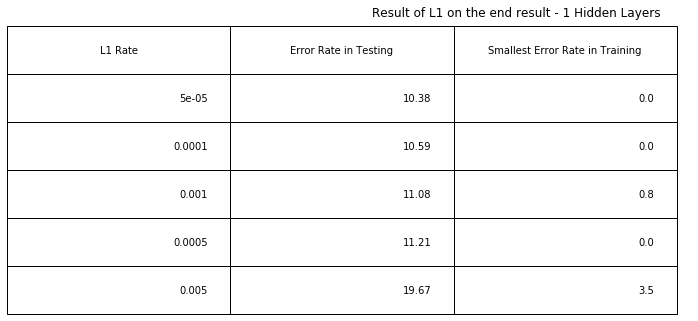

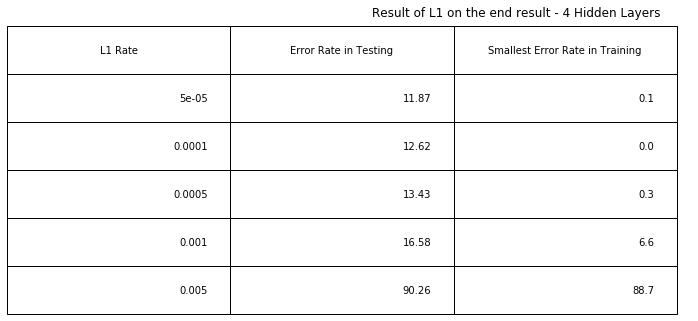

'\n\nNeed to get smallest error for each hidden layer from training to align with end test score\nMake dictionary smallest error rate and make larger then join up to the table below.\n\n'

In [3]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("l1RegExperiments")
tracker = []

l1_weight = [0.005,0.001,0.0005,0.0001,0.00005]
for val in xrange(0,5):
    #This should get the min train error
    second = shelve_p['l1F0'+str(val)][0]
    second.sort(key=lambda x: -x[1])
    tracker.append([l1_weight[val], 100-(100*shelve_p[('l1F0'+str(val))][2][1]),100.*(1.-second[0][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('L1 Rate', 'Error Rate in Testing', 'Smallest Error Rate in Training')
plt.axis('off')
plt.title('Result of L1 on the end result - 1 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
y = plt.table(cellText=tracker,colLabels=columns, loc='best')
y.scale(2,4)
plt.show()

tracker = []
for val in xrange(0,5):
    #This should get the min train error
    second = shelve_p['l1F1'+str(val)][0]
    second.sort(key=lambda x: -x[1])
    tracker.append([l1_weight[val], 100-(100*shelve_p[('l1F1'+str(val))][2][1]),100.*(1.-second[0][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
plt.axis('off')
plt.title('Result of L1 on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
y = plt.table(cellText=tracker,colLabels=columns, loc='best')
y.scale(2,4)
plt.show()

#
'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''






L2 Experiments

In [4]:
# %load Experiments/l2Experiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.000
l2_weight = [0.0005,0.0001,0.00005,0.00001,0.000005]
dp_scheduler = None

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("l2RegExperiments", writeback = True)

stats = []
rate = 2
for index,item in enumerate(l2_weight):
    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight[index])

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['l2F'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 4.719. Accuracy is 8.60%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 4.648. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 5.190. Accuracy is 57.90%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.739. Accuracy is 81.35%
INFO:mlp.optimisers:Epoch 1: Took 3 seconds. Training speed 545 pps. Validation speed 7477 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.665. Accuracy is 83.50%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 2.643. Accuracy is 85.04%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 550 pps. Validation speed 7359 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 2.472. Accuracy is 91.00%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 2.608. Accuracy is 85.25%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Training speed

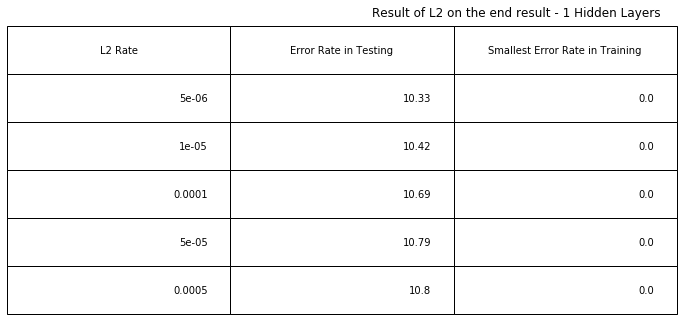

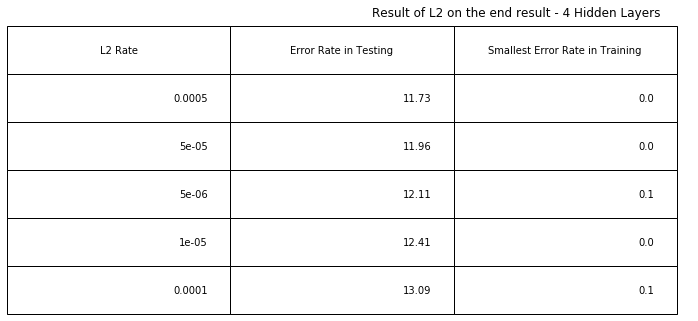

'\n\nNeed to get smallest error for each hidden layer from training to align with end test score\nMake dictionary smallest error rate and make larger then join up to the table below.\n\n'

In [5]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("l2RegExperiments")
tracker = []

l2_weight = [0.0005,0.0001,0.00005,0.00001,0.000005]
for val in xrange(0,5):
    #This should get the min train error
    second = shelve_p['l2F0'+str(val)][0]
    second.sort(key=lambda x: -x[1])
    tracker.append([l2_weight[val], 100-(100*shelve_p[('l2F0'+str(val))][2][1]),100.*(1.-second[0][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('L2 Rate', 'Error Rate in Testing', 'Smallest Error Rate in Training')
plt.axis('off')
plt.title('Result of L2 on the end result - 1 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
y = plt.table(cellText=tracker,colLabels=columns, loc='best')
y.scale(2,4)
plt.show()

tracker = []
for val in xrange(0,5):
    second = shelve_p['l2F1'+str(val)][0]
    second.sort(key=lambda x: -x[1])
    tracker.append([l2_weight[val], 100-(100*shelve_p[('l2F1'+str(val))][2][1]),100.*(1.-second[0][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
plt.axis('off')
plt.title('Result of L2 on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
y = plt.table(cellText=tracker,colLabels=columns, loc='best')
y.scale(2,4)
plt.show()

#
'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''







Dropout fixed Experiments

In [6]:
# %load Experiments/dropNExperiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob, DropoutFixed

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.000
l2_weight = 0.000
dropout = [0.6,0.55,0.5,0.45,0.4]

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("dropRegExperiments", writeback = True)

stats = []
rate = 2

for index,item in enumerate(dropout):
    dp_scheduler = DropoutFixed(dropout[index], dropout[index])
    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)    
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['dropNF'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.624. Accuracy is 8.60%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 3.021. Accuracy is 51.00%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.662. Accuracy is 78.81%
INFO:mlp.optimisers:Epoch 1: Took 3 seconds. Training speed 558 pps. Validation speed 7516 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.842. Accuracy is 71.40%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.521. Accuracy is 83.73%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 564 pps. Validation speed 7588 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.623. Accuracy is 80.10%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.490. Accuracy is 84.79%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Training speed

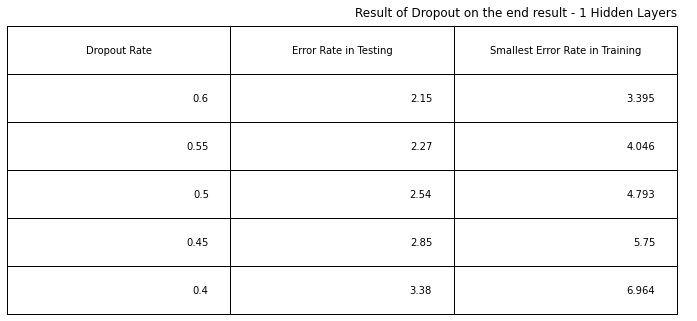

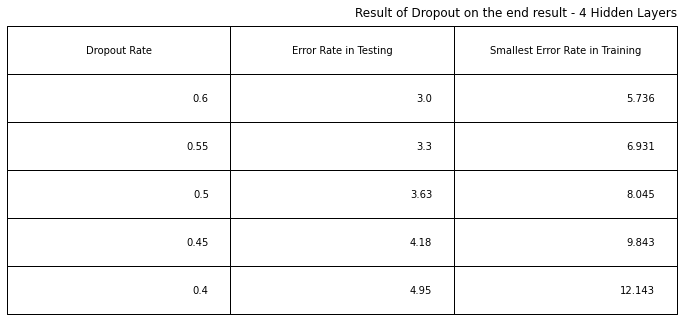

'\n\nNeed to get smallest error for each hidden layer from training to align with end test score\nMake dictionary smallest error rate and make larger then join up to the table below.\n\n'

In [2]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("dropRegExperiments")
tracker = []


dropout = [0.6,0.55,0.5,0.45,0.4]
for val in xrange(0,5):
    second = shelve_p['dropNF0'+str(val)][0]
    second.sort(key=lambda x: -x[1])
    tracker.append([dropout[val], 100-(100*shelve_p[('dropNF0'+str(val))][2][1]),100.*(1.-second[0][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Dropout Rate', 'Error Rate in Testing', 'Smallest Error Rate in Training')
plt.axis('off')
plt.title('Result of Dropout on the end result - 1 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
y = plt.table(cellText=tracker,colLabels=columns, loc='best')
y.scale(2,4)
plt.show()

tracker = []
for val in xrange(0,5):
    second = shelve_p['dropNF1'+str(val)][0]
    second.sort(key=lambda x: -x[1])
    tracker.append([dropout[val], 100-(100*shelve_p[('dropNF1'+str(val))][2][1]),100.*(1.-second[0][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
plt.axis('off')
plt.title('Result of Dropout on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
y = plt.table(cellText=tracker,colLabels=columns, loc='best')
y.scale(2,4)
plt.show()

#
'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''








In [8]:
# %load Experiments/dropNExperiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob, DropoutAnnealed

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 50
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.000
l2_weight = 0.000
dropout = [0.01]

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("dropAnnRegExperiments", writeback = True)

stats = []
rate = 2

for index,item in enumerate(dropout):
    dp_scheduler = DropoutAnnealed(0.6, 0.6, max_epochs)
    #For each number of layers, new model add layers.
    for layer in xrange(0,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 0:
            odim = 800
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)    
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['dropAF'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.624. Accuracy is 8.60%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.554. Accuracy is 9.84%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 3.053. Accuracy is 58.00%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 0.600. Accuracy is 81.41%
INFO:mlp.optimisers:Epoch 1: Took 3 seconds. Training speed 461 pps. Validation speed 8983 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 0.518. Accuracy is 83.50%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 0.497. Accuracy is 85.12%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 474 pps. Validation speed 8320 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 0.324. Accuracy is 91.00%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 0.458. Accuracy is 85.38%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Training speed

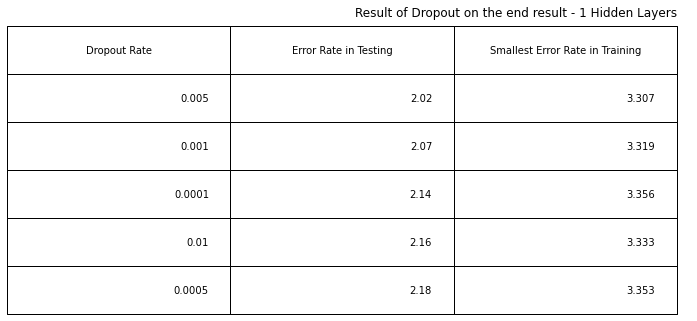

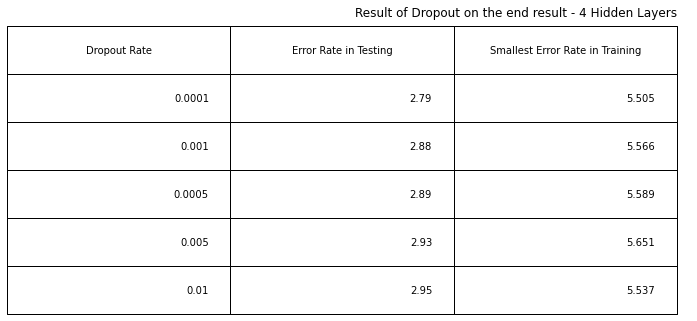

'\n\nNeed to get smallest error for each hidden layer from training to align with end test score\nMake dictionary smallest error rate and make larger then join up to the table below.\n\n'

In [4]:
import matplotlib.pyplot as plt

import shelve
%matplotlib inline
#Go through values array and put into new list.
#Open file to save to
shelve_p = shelve.open("dropAnnRegExperiments")
tracker = []


dropout = [0.01,0.005,0.001,0.0005,0.0001]
for val in xrange(0,5):
    second = shelve_p['dropAF0'+str(val)][0]
    second.sort(key=lambda x: -x[1])
    tracker.append([dropout[val], 100-(100*shelve_p[('dropAF0'+str(val))][2][1]),100.*(1.-second[0][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
columns = ('Dropout Rate', 'Error Rate in Testing', 'Smallest Error Rate in Training')
plt.axis('off')
plt.title('Result of Dropout on the end result - 1 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
y = plt.table(cellText=tracker,colLabels=columns, loc='best')
y.scale(2,4)
plt.show()

tracker = []
for val in xrange(0,5):
    second = shelve_p['dropAF1'+str(val)][0]
    second.sort(key=lambda x: -x[1])
    tracker.append([dropout[val], 100-(100*shelve_p[('dropAF1'+str(val))][2][1]),100.*(1.-second[0][1])])
    
tracker.sort(key=lambda x: x[1])
#Plot table, with these columns
plt.axis('off')
plt.title('Result of Dropout on the end result - 4 Hidden Layers')
#Test_cont is defined above - its a list of lists in the form [LearningRate, ErrorRate]
y = plt.table(cellText=tracker,colLabels=columns, loc='best')
y.scale(2,4)
plt.show()

#
'''

Need to get smallest error for each hidden layer from training to align with end test score
Make dictionary smallest error rate and make larger then join up to the table below.

'''









BEST L1 + Annealed Drop

In [9]:
# %load Experiments/dropNExperiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob, DropoutAnnealed

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 30
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.0001
l2_weight = 0.000
dropout = [0.0001]

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("dropAnnL1", writeback = True)

stats = []
rate = 2

for index,item in enumerate(dropout):
    dp_scheduler = DropoutAnnealed(0.6, 0.6, max_epochs)
    #For each number of layers, new model add layers.
    for layer in xrange(1,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)    
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['dropAF'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 7.464. Accuracy is 9.20%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 7.462. Accuracy is 10.90%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 7.670. Accuracy is 9.00%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 7.362. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 461 pps. Validation speed 7167 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 7.341. Accuracy is 10.30%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 7.329. Accuracy is 10.62%
INFO:mlp.optimisers:Epoch 2: Took 4 seconds. Training speed 430 pps. Validation speed 6081 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 7.309. Accuracy is 11.20%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 7.313. Accuracy is 9.91%
INFO:mlp.optimisers:Epoch 3: Took 4 seconds. Training speed 3

BEST ANN DROP AND L2

In [10]:
# %load Experiments/dropNExperiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob, DropoutAnnealed

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 30
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.000
l2_weight = 0.00001
dropout = [0.0001]

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("dropAnnL2", writeback = True)

stats = []
rate = 2

for index,item in enumerate(dropout):
    dp_scheduler = DropoutAnnealed(0.6, 0.6, max_epochs)
    #For each number of layers, new model add layers.
    for layer in xrange(1,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)    
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['dropAF'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.433. Accuracy is 9.20%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.431. Accuracy is 10.90%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.653. Accuracy is 9.00%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.344. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 1: Took 3 seconds. Training speed 614 pps. Validation speed 6285 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.348. Accuracy is 10.30%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 2.336. Accuracy is 10.80%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 603 pps. Validation speed 6824 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 2.340. Accuracy is 11.20%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 2.344. Accuracy is 9.91%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Training speed 6

BEST DROP + L1

In [11]:
# %load Experiments/dropNExperiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob,DropoutFixed, DropoutAnnealed

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 30
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.0001
l2_weight = 0.000
dropout = [0.4]

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("dropL1", writeback = True)

stats = []
rate = 2

for index,item in enumerate(dropout):
    dp_scheduler = DropoutFixed(0.6, 0.6)
    #For each number of layers, new model add layers.
    for layer in xrange(1,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)    
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['dropF'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 7.464. Accuracy is 9.20%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 7.462. Accuracy is 10.90%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 7.789. Accuracy is 8.90%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 7.365. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 425 pps. Validation speed 7343 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 7.359. Accuracy is 10.30%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 7.335. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 2: Took 4 seconds. Training speed 443 pps. Validation speed 7595 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 7.330. Accuracy is 11.10%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 7.317. Accuracy is 9.91%
INFO:mlp.optimisers:Epoch 3: Took 4 seconds. Training speed 44

BEST DROP + L2

In [12]:
# %load Experiments/dropNExperiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob,DropoutFixed, DropoutAnnealed

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 30
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.000
l2_weight = 0.00001
dropout = [0.4]

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("dropL2", writeback = True)

stats = []
rate = 2

for index,item in enumerate(dropout):
    dp_scheduler = DropoutFixed(0.6, 0.6)
    #For each number of layers, new model add layers.
    for layer in xrange(1,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)    
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['dropF'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 2.433. Accuracy is 9.20%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 2.431. Accuracy is 10.90%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 2.775. Accuracy is 8.80%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 2.350. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 1: Took 3 seconds. Training speed 555 pps. Validation speed 7408 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 2.367. Accuracy is 10.20%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 2.342. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 2: Took 3 seconds. Training speed 595 pps. Validation speed 7441 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 2.362. Accuracy is 11.00%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 2.349. Accuracy is 9.91%
INFO:mlp.optimisers:Epoch 3: Took 3 seconds. Training speed 56

Annealed drop + l1 and l2

In [13]:
# %load Experiments/dropNExperiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob, DropoutAnnealed

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 30
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.0001
l2_weight = 0.00001
dropout = [0.0001]

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("dropAnnL2L1", writeback = True)

stats = []
rate = 2

for index,item in enumerate(dropout):
    dp_scheduler = DropoutAnnealed(0.6, 0.6, dropout[index])
    #For each number of layers, new model add layers.
    for layer in xrange(1,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)    
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['dropAF'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 7.498. Accuracy is 9.20%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 7.496. Accuracy is 10.90%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 7.823. Accuracy is 8.90%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 7.398. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 399 pps. Validation speed 6960 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 7.391. Accuracy is 10.50%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 7.367. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 2: Took 5 seconds. Training speed 339 pps. Validation speed 5736 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 7.362. Accuracy is 10.80%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 7.350. Accuracy is 9.91%
INFO:mlp.optimisers:Epoch 3: Took 4 seconds. Training speed 37

normal drop + l1 and l2

In [14]:
# %load Experiments/dropNExperiment.py
# %load Experiments/scheduler.py
#Baseline experiment

from mlp.layers import MLP, Linear, Sigmoid, Softmax #import required layer types
from mlp.optimisers import SGDOptimiser #import the optimiser

from mlp.costs import CECost #import the cost we want to use for optimisation
from mlp.schedulers import LearningRateExponential, LearningRateFixed, LearningRateList, LearningRateNewBob,DropoutFixed, DropoutAnnealed

import numpy
import logging
import shelve
from mlp.dataset import MNISTDataProvider

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.info('Initialising data providers...')

train_dp = MNISTDataProvider(dset='train', batch_size=10, max_num_batches=100, randomize=True)
valid_dp = MNISTDataProvider(dset='valid', batch_size=10000, max_num_batches=-10, randomize=False)
test_dp = MNISTDataProvider(dset='eval', batch_size=10000, max_num_batches=-10, randomize=False)

rng = numpy.random.RandomState([2015,10,10])

#some hyper-parameters
nhid = 800
max_epochs = 30
cost = CECost()
learning_rate = 0.5;
learningList = []
decrement = (learning_rate/max_epochs)

#Regulariser weights
l1_weight = 0.0001
l2_weight = 0.00001
dropout = [0.4]

#Build list once so we don't have to rebuild every time.
for i in xrange(0,max_epochs):
    #In this order so start learning rate is added
    learningList.append(learning_rate)
    learning_rate -= decrement



#Open file to save to
shelve_r = shelve.open("dropL2L1", writeback = True)

stats = []
rate = 2

for index,item in enumerate(dropout):
    dp_scheduler = DropoutFixed(0.6, 0.6)
    #For each number of layers, new model add layers.
    for layer in xrange(1,2):
        #Set here in case we alter it in a layer experiment
        learning_rate = 0.5


        train_dp.reset()
        valid_dp.reset()
        test_dp.reset()

        logger.info("Starting ")

        #define the model
        model = MLP(cost=cost)

        if layer == 1:
            odim = 300
            model.add_layer(Sigmoid(idim=784, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))
            model.add_layer(Sigmoid(idim=odim, odim=odim, irange=0.2, rng=rng))

        #Add output layer
        model.add_layer(Softmax(idim=odim, odim=10, rng=rng))

        #Set rate scheduler here
        if rate == 1:
            lr_scheduler = LearningRateExponential(start_rate=learning_rate, max_epochs=max_epochs, training_size=100)
        elif rate == 2:
            lr_scheduler = LearningRateFixed(learning_rate=learning_rate, max_epochs=max_epochs)    
        elif rate == 3:
            # define the optimiser, here stochasitc gradient descent
            # with fixed learning rate and max_epochs
            lr_scheduler = LearningRateNewBob(start_rate=learning_rate, max_epochs=max_epochs,\
                                              min_derror_stop=.05, scale_by=0.05, zero_rate=learning_rate, patience = 10)

        optimiser = SGDOptimiser(lr_scheduler=lr_scheduler, 
                                 dp_scheduler=dp_scheduler,
                                 l1_weight=l1_weight, 
                                 l2_weight=l2_weight)

        logger.info('Training started...')
        tr_stats, valid_stats = optimiser.train(model, train_dp, valid_dp)

        logger.info('Testing the model on test set:')
        tst_cost, tst_accuracy = optimiser.validate(model, test_dp)
        logger.info('MNIST test set accuracy is %.2f %%, cost (%s) is %.3f'%(tst_accuracy*100., cost.get_name(), tst_cost))

        #Append stats for all test
        stats.append((tr_stats, valid_stats, (tst_cost, tst_accuracy)))

        #Should save rate to specific dictionairy in pickle, different key so same shelving doesn't matter
        shelve_r['dropF'+str(layer)+str(index)] = (tr_stats, valid_stats, (tst_cost, tst_accuracy))

logger.info('Saving Data')
shelve_r.close()   

INFO:root:Initialising data providers...
INFO:root:Starting 
INFO:root:Training started...
INFO:mlp.optimisers:Epoch 0: Training cost (ce) for initial model is 7.498. Accuracy is 9.20%
INFO:mlp.optimisers:Epoch 0: Validation cost (ce) for initial model is 7.496. Accuracy is 10.90%
INFO:mlp.optimisers:Epoch 1: Training cost (ce) is 7.823. Accuracy is 8.90%
INFO:mlp.optimisers:Epoch 1: Validation cost (ce) is 7.398. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 1: Took 4 seconds. Training speed 389 pps. Validation speed 7119 pps.
INFO:mlp.optimisers:Epoch 2: Training cost (ce) is 7.392. Accuracy is 10.30%
INFO:mlp.optimisers:Epoch 2: Validation cost (ce) is 7.367. Accuracy is 9.90%
INFO:mlp.optimisers:Epoch 2: Took 4 seconds. Training speed 402 pps. Validation speed 7139 pps.
INFO:mlp.optimisers:Epoch 3: Training cost (ce) is 7.362. Accuracy is 11.00%
INFO:mlp.optimisers:Epoch 3: Validation cost (ce) is 7.349. Accuracy is 9.91%
INFO:mlp.optimisers:Epoch 3: Took 4 seconds. Training speed 40